In [43]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE



In [44]:
df = pd.read_csv("/ssd003/projects/pets/datasets/homecredit_train.csv")

<AxesSubplot:>

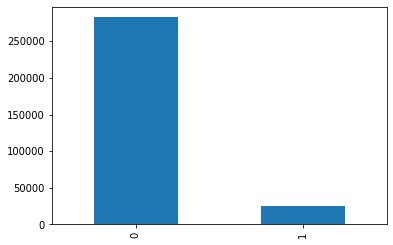

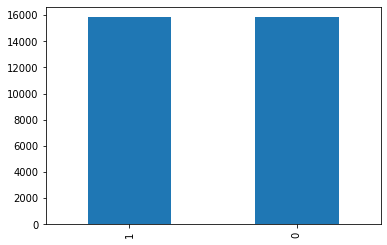

In [45]:
fig, ax = plt.subplots()
df['target'].value_counts().plot(ax=ax, kind='bar')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Oversampling target labels
max_size = train_df['target'].value_counts().max()

# lst = [train_df]
# for class_index, group in train_df.groupby('target'):
#     lst.append(group.sample(max_size-len(group), replace=True))
# X_train = pd.concat(lst)

X_train = train_df.drop(['target'], axis=1)
y_train = train_df['target']

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_test = test_df.drop(['target'], axis=1)
y_test = test_df['target']

X_val = val_df.drop(['target'], axis=1)
y_val = val_df['target']

fig, ax = plt.subplots()
y_train.value_counts().plot(ax=ax, kind='bar')



In [46]:
scaler = StandardScaler()
X_train_transform = scaler.fit_transform(X_train)
X_val_transform = scaler.transform(X_val)
X_test_transform = scaler.transform(X_test)

X_train_transform = pd.DataFrame(X_train_transform,columns = X_train.columns)
X_val_transform = pd.DataFrame(X_val_transform,columns = X_train.columns)
X_test_transform = pd.DataFrame(X_test_transform, columns = X_train.columns)

# BASELINE MODEL

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


params = {
    "layer1": 400,
    "layer2": 160,
    "layer3": 64,
    "layer4": 26,
    "layer5": 12,
    "epochs": 1000,
    "dropout": 0.3
}

nn = Sequential()
nn.add(Dense(units = params['layer1'] , input_dim = X_train.shape[-1]))
nn.add(PReLU())
nn.add(Dropout(params['dropout']))
nn.add(Dense(units = params['layer2'] ))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(params['dropout']))
nn.add(Dense(units = params['layer3']))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(params['dropout']))
nn.add(Dense(units = params['layer4']))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(params['dropout']))
nn.add(Dense(units = params['layer5']))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(params['dropout']))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


In [48]:
history = model.fit(X_train_transform, y_train, epochs=50, batch_size=32, validation_data=(X_val_transform, y_val))

Epoch 1/50
990/990 [==============================] - 9s 9ms/step - loss: 0.6458 - tp: 11244.0000 - fp: 5435.0000 - tn: 10399.0000 - fn: 4590.0000 - accuracy: 0.6834 - precision: 0.6741 - recall: 0.7101 - auc: 0.7504 - prc: 0.7290 - val_loss: 0.7543 - val_tp: 2998.0000 - val_fp: 19779.0000 - val_tn: 25381.0000 - val_fn: 1044.0000 - val_accuracy: 0.5768 - val_precision: 0.1316 - val_recall: 0.7417 - val_auc: 0.7124 - val_prc: 0.1891
Epoch 2/50
990/990 [==============================] - 9s 9ms/step - loss: 0.6332 - tp: 11091.0000 - fp: 4955.0000 - tn: 10879.0000 - fn: 4743.0000 - accuracy: 0.6938 - precision: 0.6912 - recall: 0.7005 - auc: 0.7628 - prc: 0.7449 - val_loss: 0.7000 - val_tp: 2724.0000 - val_fp: 16468.0000 - val_tn: 28692.0000 - val_fn: 1318.0000 - val_accuracy: 0.6385 - val_precision: 0.1419 - val_recall: 0.6739 - val_auc: 0.7087 - val_prc: 0.1872
Epoch 3/50
990/990 [==============================] - 8s 9ms/step - loss: 0.6280 - tp: 11205.0000 - fp: 4948.0000 - tn: 10886.00

In [ ]:
scores = model.evaluate(X_test_transform, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

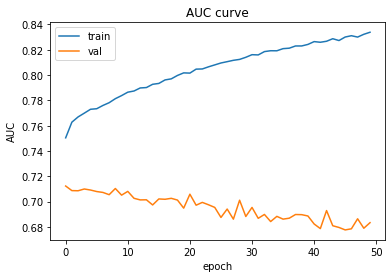

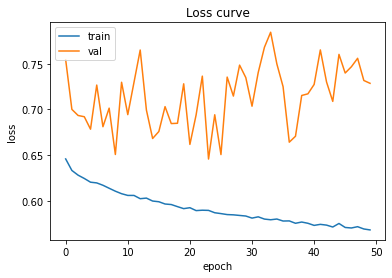

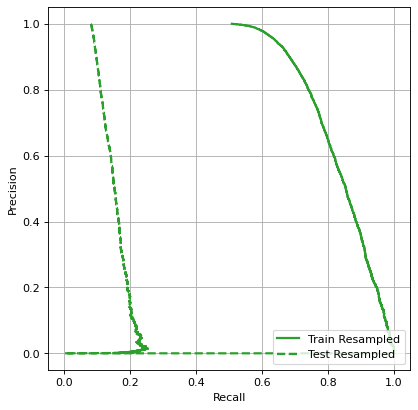

In [49]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC curve')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
train_predictions_resampled = model.predict(X_train, batch_size=128)
test_predictions_resampled =  model.predict(X_test, batch_size=128)
plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')



# results = model.evaluate(X_test, y_test, batch_size=64)

In [50]:
y_pred = model.predict(X_test_transform)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["0","1"])

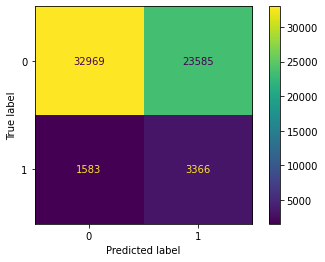

In [52]:
disp.plot()